<a href="https://colab.research.google.com/github/fabiano-mahler/hello-world/blob/master/cleveland_cvd_standard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
!pip install dfply ## instala o pacote DFPLY
!pip install scikit-plot ## instala o pacote SCIKIT-PLOT
!pip install xgboost
!pip install graphviz
!pip install python-graphviz

!pip install dtreeviz
!pip install pandas-profiling

ERROR: Could not find a version that satisfies the requirement python-graphviz (from versions: none)
ERROR: No matching distribution found for python-graphviz


In [0]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

### biblioteca SCIKIT-LEARN
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


import random

from dfply import *

import scikitplot as skplt

from dtreeviz.trees import *

import pandas_profiling


import warnings
warnings.filterwarnings("ignore")

In [104]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
df=pd.read_csv('gdrive/My Drive/cleveland.csv')


In [106]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,binaryClass
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,P
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,N
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,N
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,P
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,P
5,56,1,2,120,236,0,0,178,0,0.8,1,0,3,P
6,62,0,4,140,268,0,2,160,0,3.6,3,2,3,N
7,57,0,4,120,354,0,0,163,1,0.6,1,0,3,P
8,63,1,4,130,254,0,2,147,0,1.4,2,1,7,N
9,53,1,4,140,203,1,2,155,1,3.1,3,0,7,N


In [107]:
profile = pandas_profiling.ProfileReport(df)
profile

Number of variables,14
Number of observations,303
Total Missing (%),0.0%
Total size in memory,33.3 KiB
Average record size in memory,112.4 B
Numeric,8
Categorical,3
Boolean,3
Date,0
Text (Unique),0
Rejected,0


In [0]:
df_cvd = (df >>
               drop(X.ca, X.thal, X.thalach)
              )

In [109]:
df_cvd.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,exang,oldpeak,slope,binaryClass
0,63,1,1,145,233,1,2,0,2.3,3,P
1,67,1,4,160,286,0,2,1,1.5,2,N
2,67,1,4,120,229,0,2,1,2.6,2,N
3,37,1,3,130,250,0,0,0,3.5,3,P
4,41,0,2,130,204,0,2,0,1.4,1,P


In [110]:
df_cvd.dtypes

age              int64
sex              int64
cp               int64
trestbps         int64
chol             int64
fbs              int64
restecg          int64
exang            int64
oldpeak        float64
slope            int64
binaryClass     object
dtype: object

In [111]:
'''from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df_cvd.drop(['binaryClass'], axis=1)
y = df_cvd['binaryClass']
X = StandardScaler().fit_transform(X)
y = LabelEncoder().fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
df_cvd.head()'''


"from sklearn.preprocessing import StandardScaler\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.model_selection import train_test_split\n\nX = df_cvd.drop(['binaryClass'], axis=1)\ny = df_cvd['binaryClass']\nX = StandardScaler().fit_transform(X)\ny = LabelEncoder().fit_transform(y)\n\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)\ndf_cvd.head()"

In [0]:
#@title TESTE DUMMIES

In [0]:
df_cvd = pd.get_dummies(df_cvd, columns=['sex', 'cp', 'fbs', 'exang', 'slope', 'restecg'])

In [114]:
df_cvd.head(10)

,age,trestbps,chol,oldpeak,binaryClass,sex_0,sex_1,cp_1,cp_2,cp_3,cp_4,fbs_0,fbs_1,exang_0,exang_1,slope_1,slope_2,slope_3,restecg_0,restecg_1,restecg_2
0,63,145,233,2.3,P,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0,1
1,67,160,286,1.5,N,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,1
2,67,120,229,2.6,N,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,1
3,37,130,250,3.5,P,0,1,0,0,1,0,1,0,1,0,0,0,1,1,0,0
4,41,130,204,1.4,P,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1
5,56,120,236,0.8,P,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0
6,62,140,268,3.6,N,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1
7,57,120,354,0.6,P,1,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0
8,63,130,254,1.4,N,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,1
9,53,140,203,3.1,N,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1


In [0]:
#@title TESTE PADRONIZAÇÃO

In [0]:
df_cvd = pd.DataFrame.from_records(df_cvd)

In [0]:
variaveis_preditoras = df_cvd.iloc[:, df_cvd.columns != 'binaryClass']
classe = df_cvd.iloc[:, df_cvd.columns == 'binaryClass']
X_train, X_test, y_train, y_test = train_test_split(variaveis_preditoras, 
                                                    classe,
                                                    train_size = 0.70,
                                                    random_state = 42)

In [0]:
X_train_columns = X_train.columns

In [0]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

(array([ 96.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 116.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

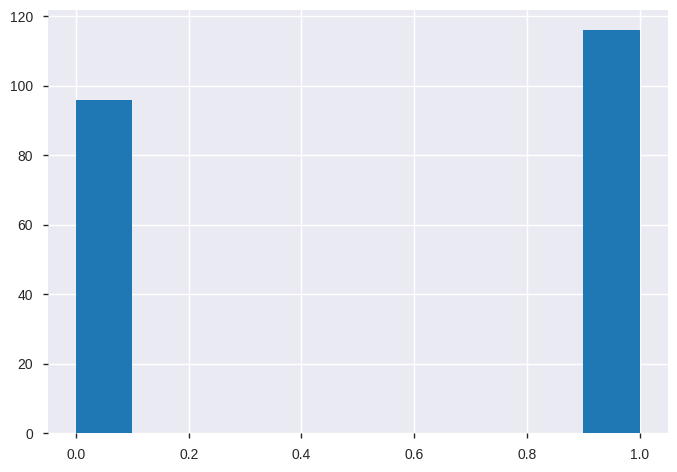

In [120]:
plt.hist(y_train)

(array([43.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 48.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

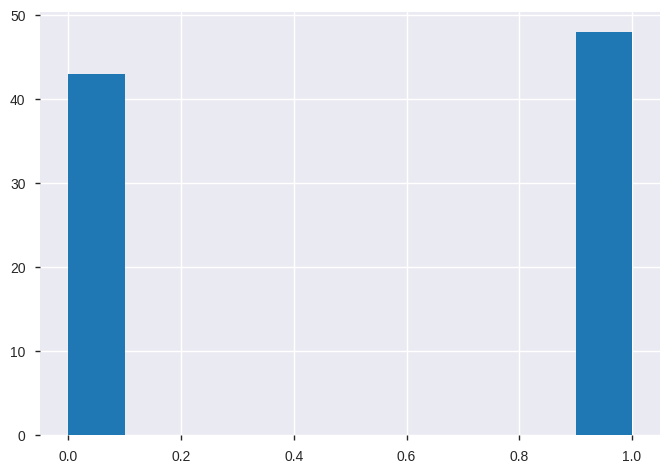

In [121]:
plt.hist(y_test)

In [0]:
from sklearn.compose import ColumnTransformer

### variáveis contínuas que serão padronizadas
continuous_cols = ['age',	'trestbps',	'chol']


def setScaler():
  ct = ColumnTransformer([
        ('scaler', StandardScaler(), continuous_cols)
    ], remainder='passthrough'
  )
  return ct
  
scaler = setScaler()

In [123]:
scaler.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('scaler',
                                 StandardScaler(copy=True, with_mean=True,
                                                with_std=True),
                                 ['age', 'trestbps', 'chol'])],
                  verbose=False)

In [0]:
X_train = scaler.transform(X_train)

In [0]:
X_test = scaler.transform(X_test)

In [126]:
pd.DataFrame(X_train, columns=X_train_columns).head(10)

,age,trestbps,chol,oldpeak,sex_0,sex_1,cp_1,cp_2,cp_3,cp_4,fbs_0,fbs_1,exang_0,exang_1,slope_1,slope_2,slope_3,restecg_0,restecg_1,restecg_2
0,1.124144,0.301038,0.761835,1.4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.796333,-0.664307,0.445233,1.8,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.249982,0.944601,-1.644337,1.6,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.249982,0.408298,-1.137775,0.4,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.359252,-1.736912,0.044205,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,1.670495,-0.128004,1.606106,2.4,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6,0.577792,0.944601,0.255273,2.6,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7,0.468522,2.017206,1.690533,3.4,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
8,1.233414,-1.093349,-0.715639,0.1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
9,0.249982,0.944601,0.635194,0.6,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [0]:
def runModel(model, X_train, y_train, X_test, y_test, confusion_matrix=True, normalizeCM=False, roc=True, plot_calibration=True, random_state=42, title="", pos_label=1):
    """Função auxiliar para execução de modelos de classificação.
    
    Parâmetros:
    
    - model: modelo de classificação a ser executado
    - X_train: base de treinamento das variáveis preditoras
    - y_train: base de treinamento da classe
    - X_test: base de teste das variáveis preditoras
    - y_test: base de teste da classe
    - confusion_matrix (default: True): exibir a matriz de confusão da classificação
    - normalizeCM (default: False): define se a matriz de confusão será normalizada
    - roc (default: True): define se será exibida a curva ROC para o classificador
    - plot_calibration (default: True): define se será exibida a curva de calibração para o classificador
    - title: define o título a ser exibido nos gráficos
    - pos_label: indica qual o valor de y_train e y_test que representa a classe positiva. O valor default é 1. 

    """
    clf = model
    name = title
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
        
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    if confusion_matrix:
       skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=normalizeCM, title=name)
    if roc:
       skplt.metrics.plot_roc(y_test, prob_pos, plot_micro=False, plot_macro=False, classes_to_plot=[1], title=name,figsize=(10,10))
               
    prob_pos = prob_pos[:,1]
    clf_score = brier_score_loss(y_test, prob_pos, pos_label=pos_label)
    print("%s:" % name)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
    print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))
        
    if plot_calibration:
      
      fraction_of_positives, mean_predicted_value = \
                calibration_curve(y_test, prob_pos, n_bins=10)
      plt.rcParams.update({'font.size': 22})
      plt.rc('legend',**{'fontsize':22})
      fig = plt.figure(3, figsize=(10, 10))
      ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
      ax2 = plt.subplot2grid((3, 1), (2, 0))
      ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado",)
      ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                     label="%s (%1.3f)" % (name, clf_score))

      ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                     histtype="step", lw=2)

      ax1.set_ylabel("Fração de positivos")
      ax1.set_ylim([-0.05, 1.05])
      ax1.legend(loc="lower right")
      ax1.set_title('Gráfico de Calibração  (reliability curve)')
      
      ax2.set_xlabel("Valor médio predito")
      ax2.set_ylabel("Quantidade")
      ax2.legend(loc="upper center", ncol=2)
      
      for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(22)
        
      for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(22)
      
      plt.tight_layout()
      plt.show()
    
    
    

In [0]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [129]:
help(runModel)

Help on function runModel in module __main__:

runModel(model, X_train, y_train, X_test, y_test, confusion_matrix=True, normalizeCM=False, roc=True, plot_calibration=True, random_state=42, title='', pos_label=1)
    Função auxiliar para execução de modelos de classificação.
    
    Parâmetros:
    
    - model: modelo de classificação a ser executado
    - X_train: base de treinamento das variáveis preditoras
    - y_train: base de treinamento da classe
    - X_test: base de teste das variáveis preditoras
    - y_test: base de teste da classe
    - confusion_matrix (default: True): exibir a matriz de confusão da classificação
    - normalizeCM (default: False): define se a matriz de confusão será normalizada
    - roc (default: True): define se será exibida a curva ROC para o classificador
    - plot_calibration (default: True): define se será exibida a curva de calibração para o classificador
    - title: define o título a ser exibido nos gráficos
    - pos_label: indica qual o valor

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
lr = LogisticRegression()

Regressão Logística:
	Brier: 0.159
	Precision: 0.818
	Recall: 0.750
	F1: 0.783



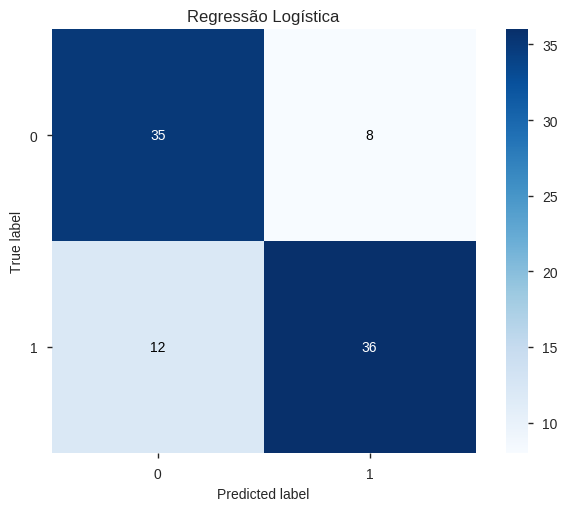

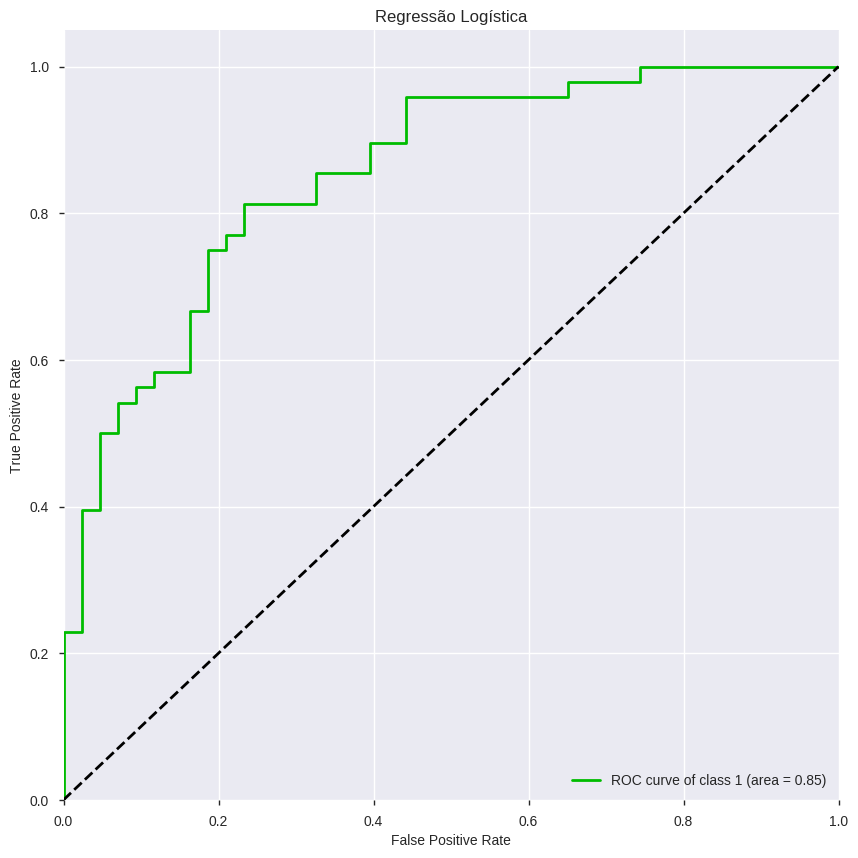

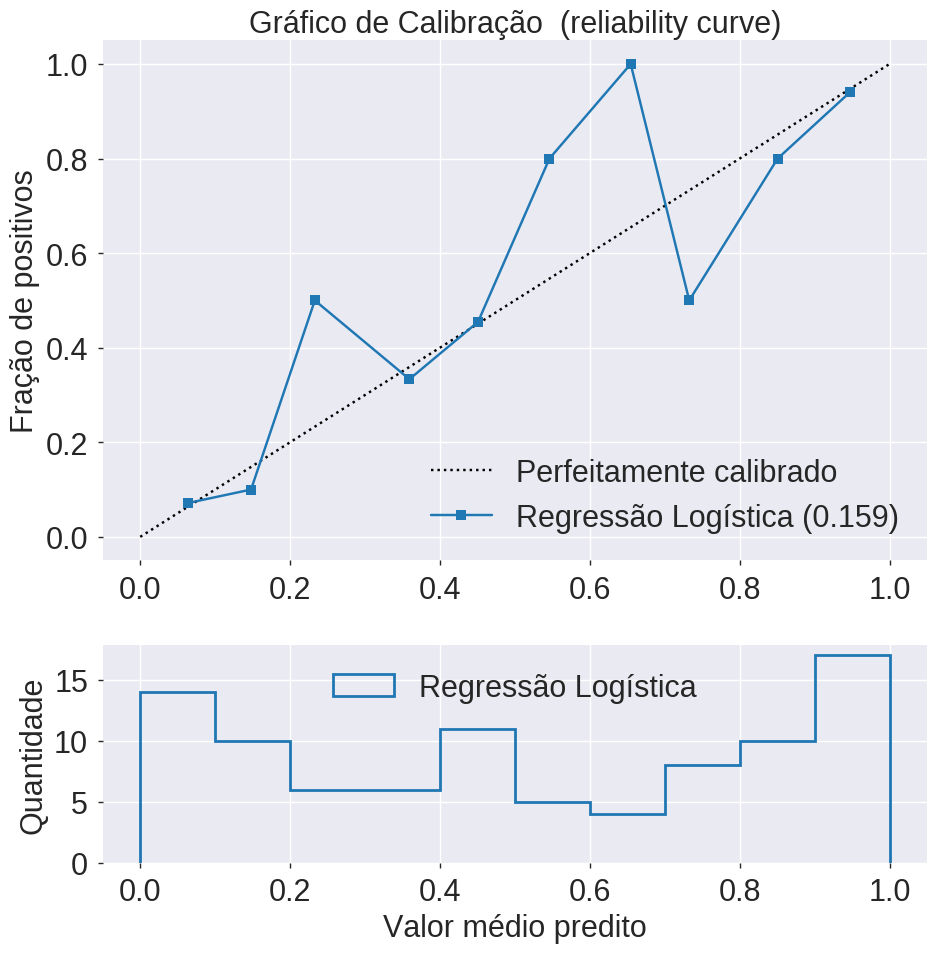

In [132]:
runModel(lr, X_train, y_train, X_test, y_test, title="Regressão Logística")

In [0]:
# criando a random forest

fit_rf = RandomForestClassifier(random_state=42, verbose=1)



In [0]:
np.random.seed(42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### Caso deseje rodar GridSearchCV, troque a linha acima pela que segue

cv_rf = GridSearchCV(fit_rf, cv=3, param_grid=param_grid,
                     n_jobs = -1) 

cv_rf = RandomizedSearchCV(fit_rf, n_iter=50, cv=3, verbose=1, param_distributions=param_grid,
                     n_jobs = -1)



In [135]:
cv_rf.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [0]:
rf = cv_rf.best_estimator_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Random Forest:
	Brier: 0.148
	Precision: 0.787
	Recall: 0.771
	F1: 0.779



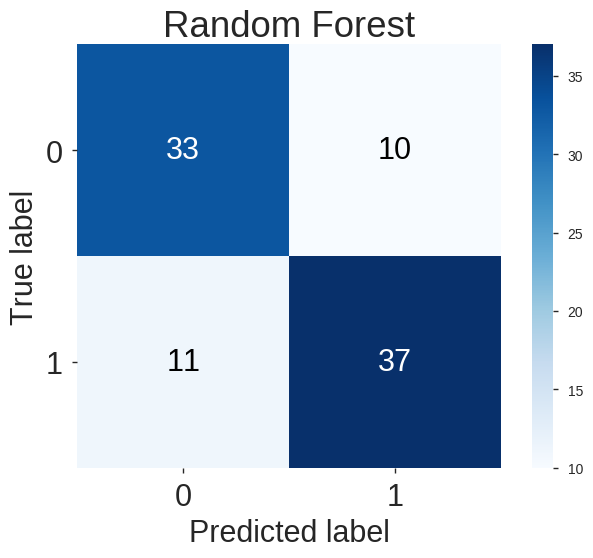

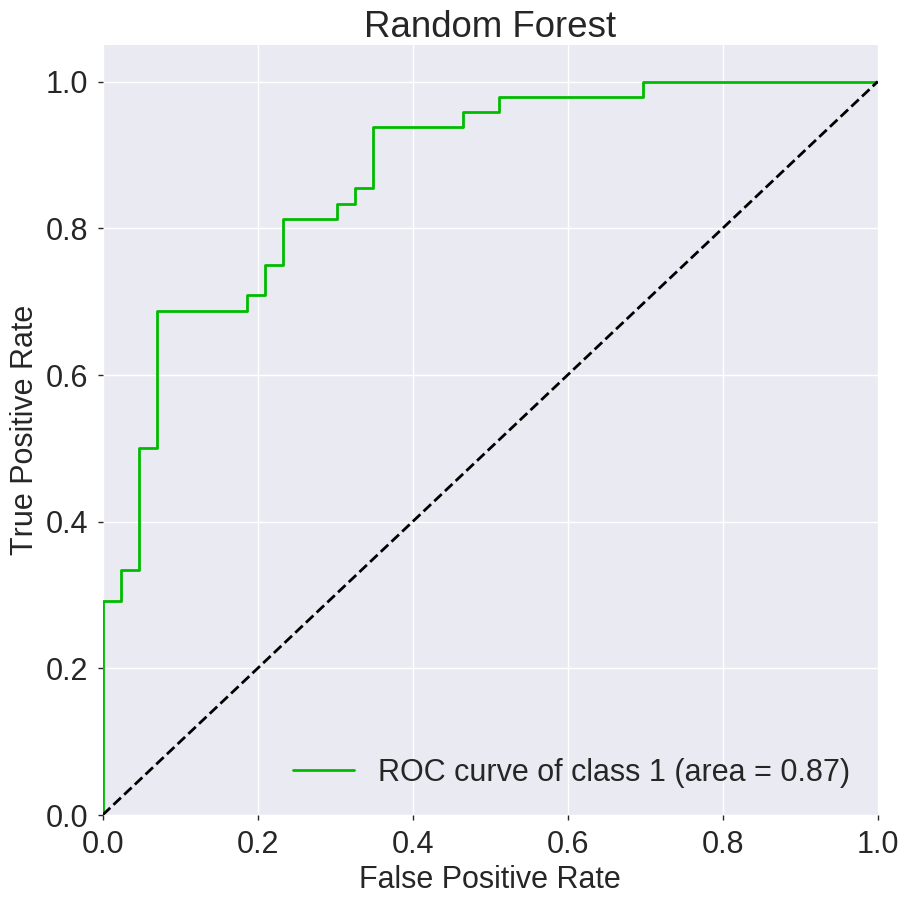

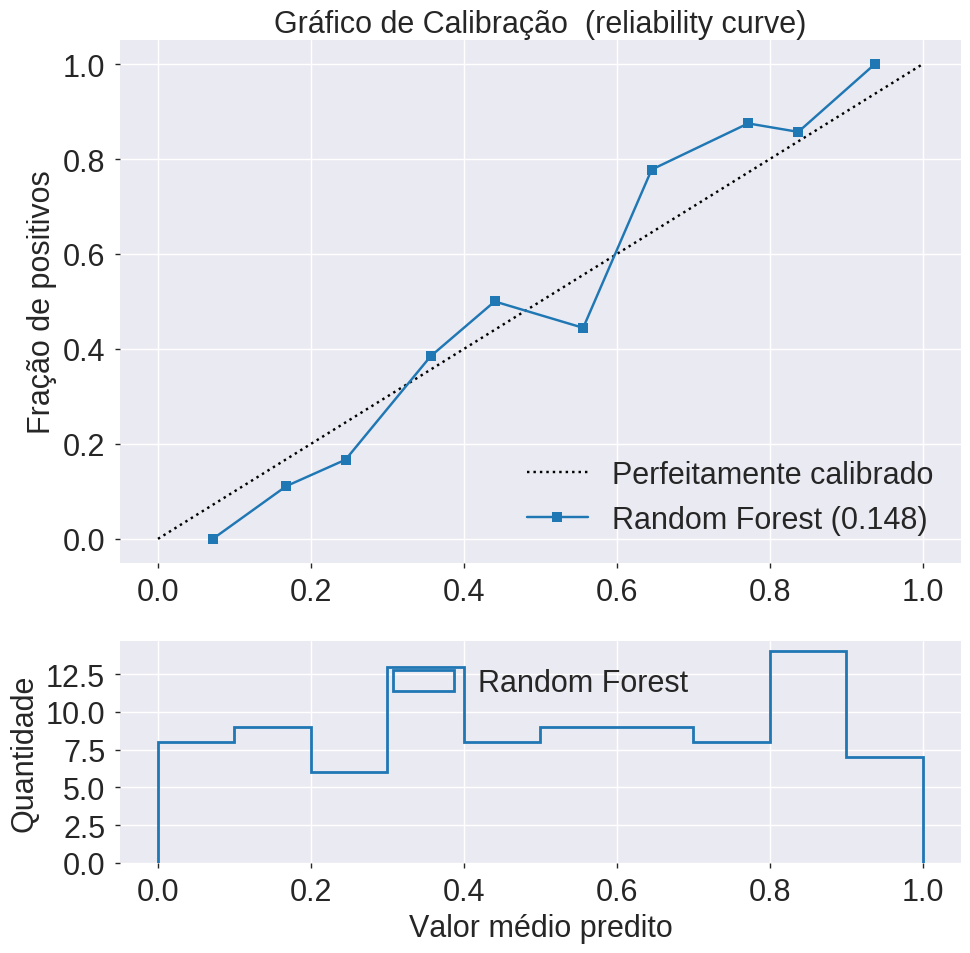

In [137]:
runModel(rf, X_train, y_train, X_test, y_test, title="Random Forest")

In [138]:
df_cvd.shape

(303, 21)

In [0]:
from sklearn import neural_network

In [0]:
rna = neural_network.MLPClassifier(activation='tanh', alpha=0.1, batch_size=5, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=7, learning_rate='constant',
       learning_rate_init=0.1, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

RNA:
	Brier: 0.254
	Precision: 0.767
	Recall: 0.688
	F1: 0.725



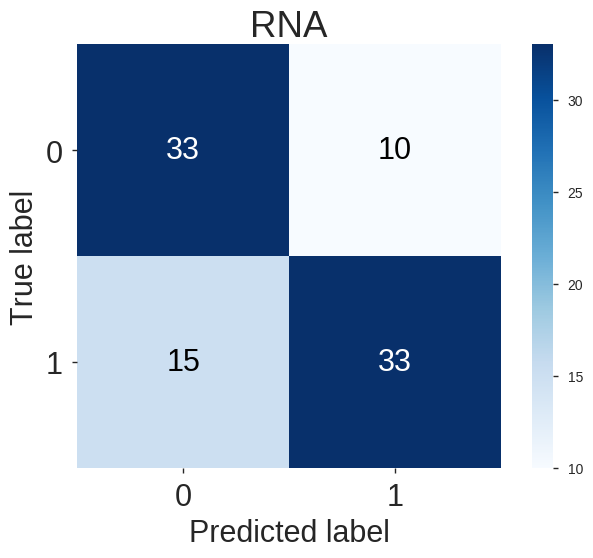

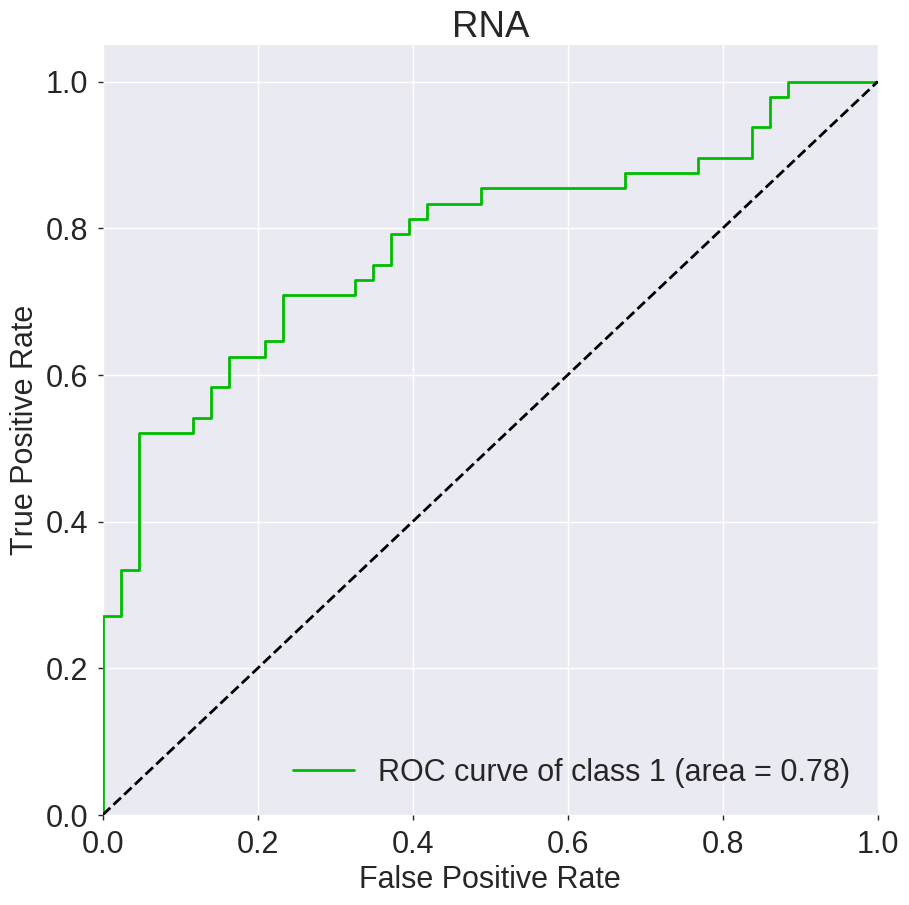

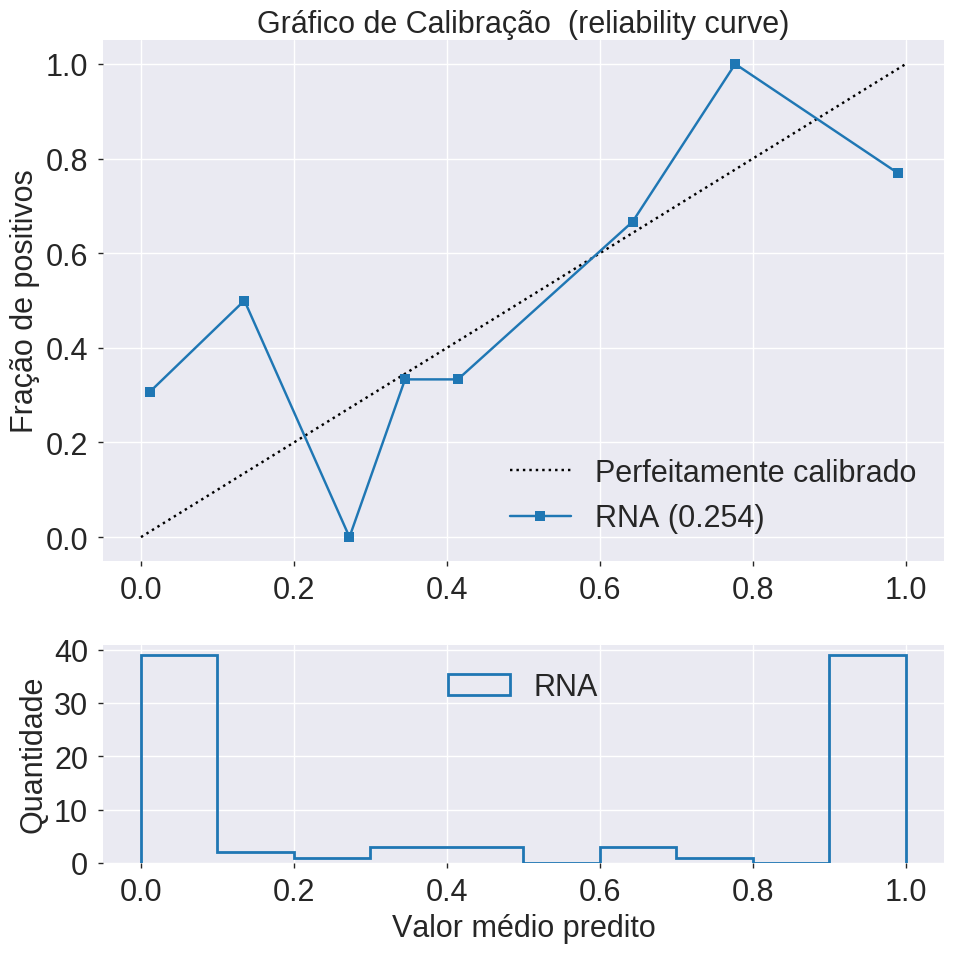

In [141]:
runModel(rna, X_train, y_train, X_test, y_test, title="RNA")

In [142]:
'''def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(rna, "RNA", 1)

# Plot calibration curve for Linear SVC
plot_calibration_curve(rf, "RANDOM FOREST", 2)

plt.show()
'''

'def plot_calibration_curve(est, name, fig_index):\n    """Plot calibration curve for est w/o and with calibration. """\n    # Calibrated with isotonic calibration\n    isotonic = CalibratedClassifierCV(est, cv=2, method=\'isotonic\')\n\n    # Calibrated with sigmoid calibration\n    sigmoid = CalibratedClassifierCV(est, cv=2, method=\'sigmoid\')\n\n    # Logistic regression with no calibration as baseline\n    lr = LogisticRegression(C=1.)\n\n    fig = plt.figure(fig_index, figsize=(10, 10))\n    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)\n    ax2 = plt.subplot2grid((3, 1), (2, 0))\n\n    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")\n    for clf, name in [(lr, \'Logistic\'),\n                      (est, name),\n                      (isotonic, name + \' + Isotonic\'),\n                      (sigmoid, name + \' + Sigmoid\')]:\n        clf.fit(X_train, y_train)\n        y_pred = clf.predict(X_test)\n        if hasattr(clf, "predict_proba"):\n            prob_pos =

In [0]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2,5,8,15,20],
              "max_depth": [2,4,6,8,10],
              "min_samples_leaf": [1,2,4,8,10],
              "max_leaf_nodes": [2,4, 7,9, 12, 20],
              }
dt = DecisionTreeClassifier(random_state=42)
cv_dt = GridSearchCV(dt, cv = 3,
                     param_grid=param_grid,
                     n_jobs = -1)

In [144]:
cv_dt.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                       

In [145]:
cv_dt

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                       

In [146]:
report(cv_dt.cv_results_)


Model with rank: 1
Mean validation score: 0.769 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.764 (std: 0.033)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}

Model with rank: 2
Mean validation score: 0.764 (std: 0.033)
Parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.764 (std: 0.033)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}



In [0]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=6, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=20)

Árvore de Decisão:
	Brier: 0.180
	Precision: 0.780
	Recall: 0.667
	F1: 0.719



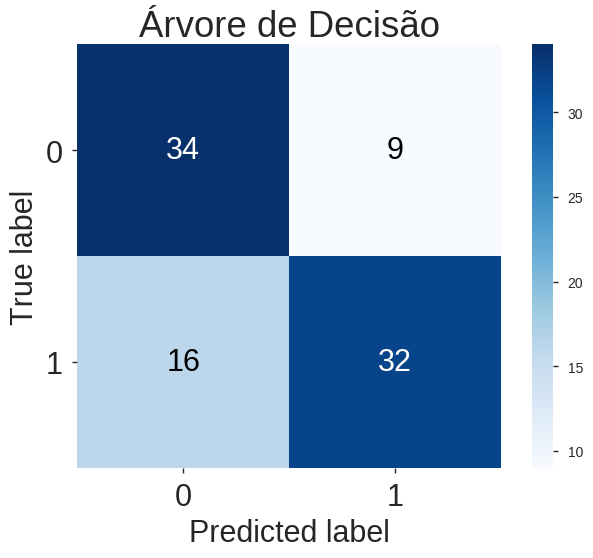

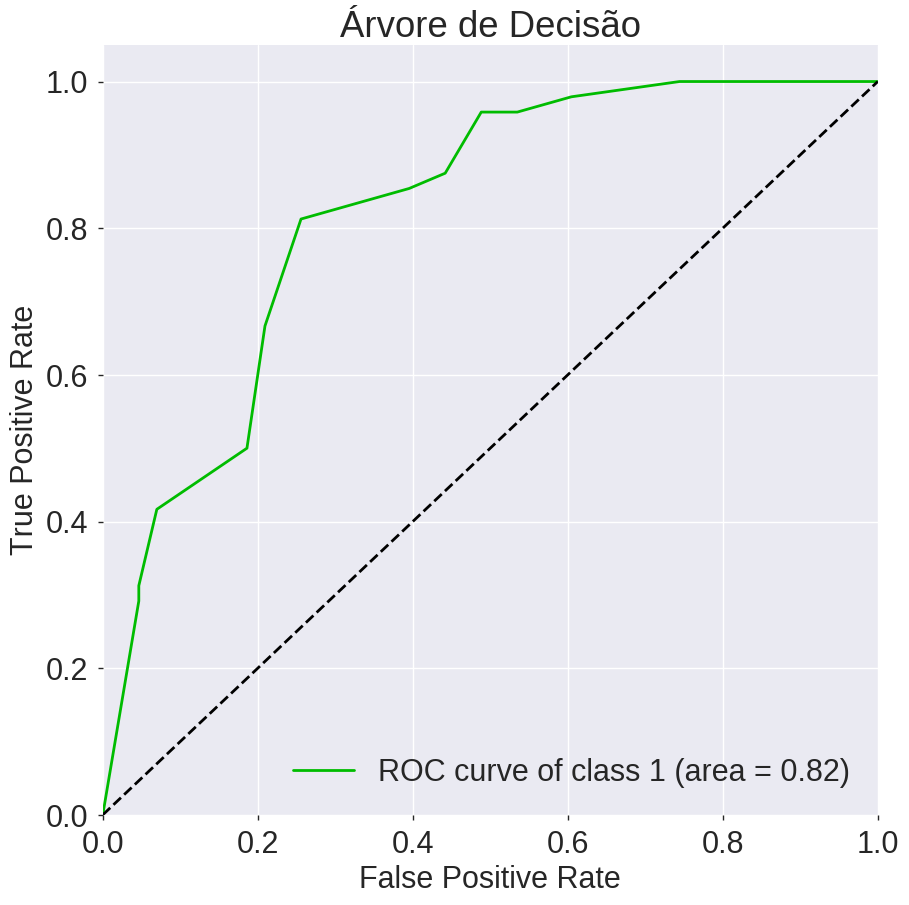

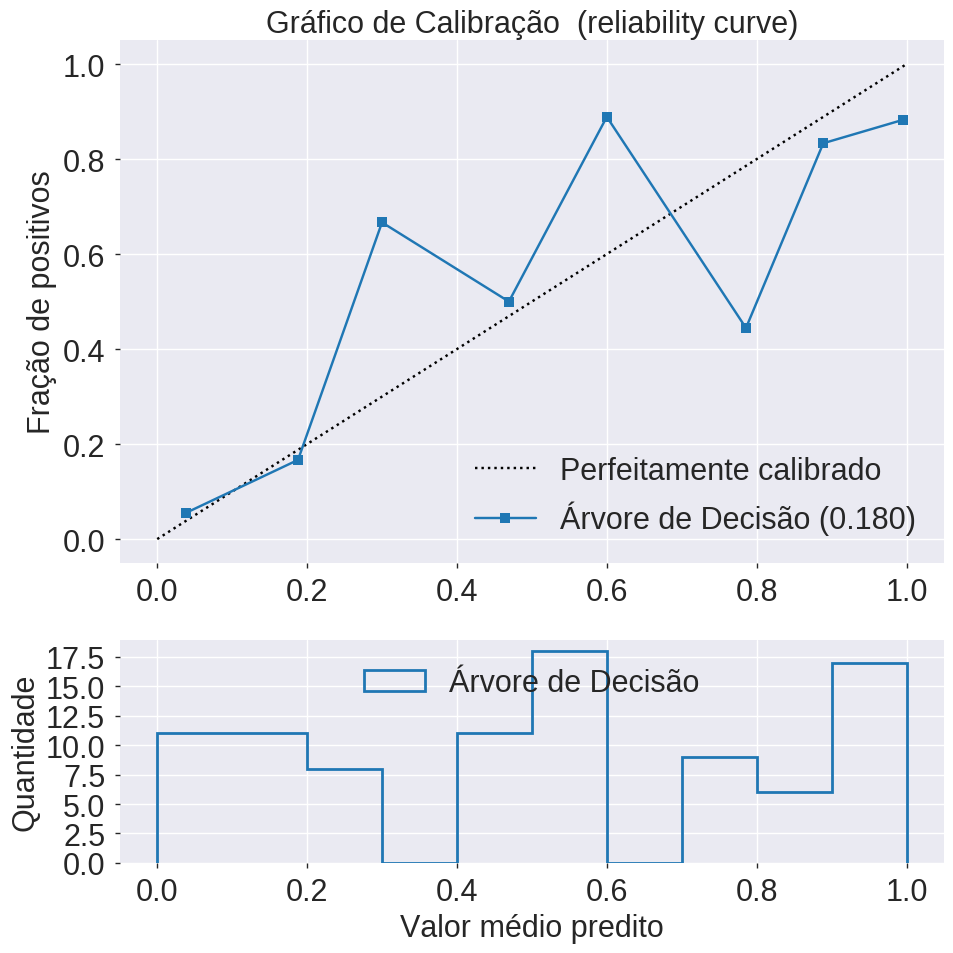

In [148]:
runModel(dt, X_train, y_train, X_test, y_test, title="Árvore de Decisão")